In [531]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/var/folders/8q/kf4dndkj2zz0h4h9x0xscv0w0000gn/T/ipykernel_55262/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Project 2. Due by Thursday, February 27. ##

For this project we will use the **New York Electric Grid (NYISO) Data**.

Throughout, we will compute the length of a link as computed using the latitude and longitude of each node (termed 'bus' in the data set).

1. Repeat one million times: take a randomly chosen pair of nodes A and B, and compute the length of a shortest path between them. You can use any library for this purpose. Plot a histogram showing the distribution of lengths.

2. Implement the algorithm for the minimum-cost node tour problem (i.e., the node inspection problem) on this data.  You only need to examine **one** pairing of the odd nodes. You only need to report on the **cost** of your tour, that is to say you do not need to implement the splicing operation.

3. Now repeat step 2, examining *random* pairings of the odd nodes.  Perform this step for at least 1000 pairings.  The TA/CA may ask to perform more.  Report on the best solution you find.

4. Extra credit (**only do this if 1-3 are 100% completed**).  Use the 'splicing' algorithm to actually compute the tour itself, for the best solution obtained in Step 3.


### Preprocess

In [532]:
import pandas as pd
import numpy as np
import geopy.distance
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.csgraph as csgraph
from tqdm import tqdm
import networkx as nx
import random
from scipy.sparse.csgraph import dijkstra
from scipy.optimize import linear_sum_assignment


In [533]:
df_branch = pd.read_csv('nyisobranches.csv')
df_bus = pd.read_csv('nyisobuses.csv', skiprows=1)

In [534]:
df_branch.head()

,branch number,first bus number,second bus number
0,1,123,4232
1,2,187,3532
2,3,239,76466
3,4,338,8443
4,5,845,8079


In [535]:
df_branch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2203 entries, 0 to 2202
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   branch number       2203 non-null   int64
 1    first bus number   2203 non-null   int64
 2    second bus number  2203 non-null   int64
dtypes: int64(3)
memory usage: 51.8 KB


In [536]:
df_bus.head()

,Number,Name,Area Name,Latitude,Longitude,Status,# Neighbors (in service only),Nom kV,PU Volt,Volt (kV),...,Gen Min MW,Gen Max MW,Gen Min Mvar,Gen Max Mvar,Switched Shunts Mvar,Switched Shunts Nom Mvar,Max Mvar,Min Mvar,Area Num,Zone Num
0,123,J C McNeil,Vermont,44.492,-73.208,Connected,1,138.0,0.99773,137.686,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35,1
1,187,9001043100,Connecticut,41.110,-73.457,Connected,1,138.0,0.99500,137.310,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1
2,239,9001071000,Connecticut,41.172,-73.218,Connected,1,230.0,1.00859,231.975,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1
3,338,9001245500,Connecticut,41.275,-73.516,Connected,1,138.0,0.95884,132.319,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1
4,845,9011690300,Connecticut,41.293,-72.925,Connected,1,138.0,0.98595,136.062,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1


In [537]:
df_bus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1814 entries, 0 to 1813
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Number                         1814 non-null   int64  
 1   Name                           1814 non-null   object 
 2   Area Name                      1814 non-null   object 
 3   Latitude                       1814 non-null   float64
 4   Longitude                      1814 non-null   float64
 5   Status                         1814 non-null   object 
 6   # Neighbors (in service only)  1814 non-null   int64  
 7   Nom kV                         1814 non-null   float64
 8   PU Volt                        1814 non-null   float64
 9   Volt (kV)                      1814 non-null   float64
 10  Angle (Deg)                    1814 non-null   float64
 11  Load MVA                       1611 non-null   float64
 12  Load MW                        1611 non-null   f

In [538]:
df_merged = df_branch.merge(df_bus[['Number', 'Latitude', 'Longitude']],\
                         left_on=' first bus number', right_on='Number',\
                         how='left').rename(columns={'Latitude': 'Latitude1', 'Longitude': 'Longitude1'}).drop(columns=['Number'])

df_merged = df_merged.merge(df_bus[['Number', 'Latitude', 'Longitude']],\
                         left_on=' second bus number', right_on='Number',\
                         how='left').rename(columns={'Latitude': 'Latitude2', 'Longitude': 'Longitude2'}).drop(columns=['Number'])

df_merged.info() # no missing value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2203 entries, 0 to 2202
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   branch number       2203 non-null   int64  
 1    first bus number   2203 non-null   int64  
 2    second bus number  2203 non-null   int64  
 3   Latitude1           2203 non-null   float64
 4   Longitude1          2203 non-null   float64
 5   Latitude2           2203 non-null   float64
 6   Longitude2          2203 non-null   float64
dtypes: float64(4), int64(3)
memory usage: 120.6 KB


In [539]:
# use latitude and longitude to calculate the straight-line distance
def calculate_distance(row):
    coords_1 = (row["Latitude1"], row["Longitude1"])
    coords_2 = (row["Latitude2"], row["Longitude2"])
    return geopy.distance.geodesic(coords_1, coords_2).miles # shortest distance between two points in miles

df_merged["straight_distance(miles)"] = df_merged.apply(calculate_distance, axis=1) # apply the function to each row of the table
df_merged.head()

,branch number,first bus number,second bus number,Latitude1,Longitude1,Latitude2,Longitude2,straight_distance(miles)
0,1,123,4232,44.492,-73.208,44.581,-73.580,19.372320
1,2,187,3532,41.110,-73.457,40.827,-73.647,21.911667
2,3,239,76466,41.172,-73.218,41.573,-73.965,47.683149
3,4,338,8443,41.275,-73.516,41.280,-73.583,3.504998
4,5,845,8079,41.293,-72.925,40.924,-72.762,26.847181


### 1. Repeat one million times: take a randomly chosen pair of nodes A and B, and compute the length of a shortest path between them. You can use any library for this purpose. Plot a histogram showing the distribution of lengths.

100%|██████████| 1000000/1000000 [00:23<00:00, 41806.75it/s]


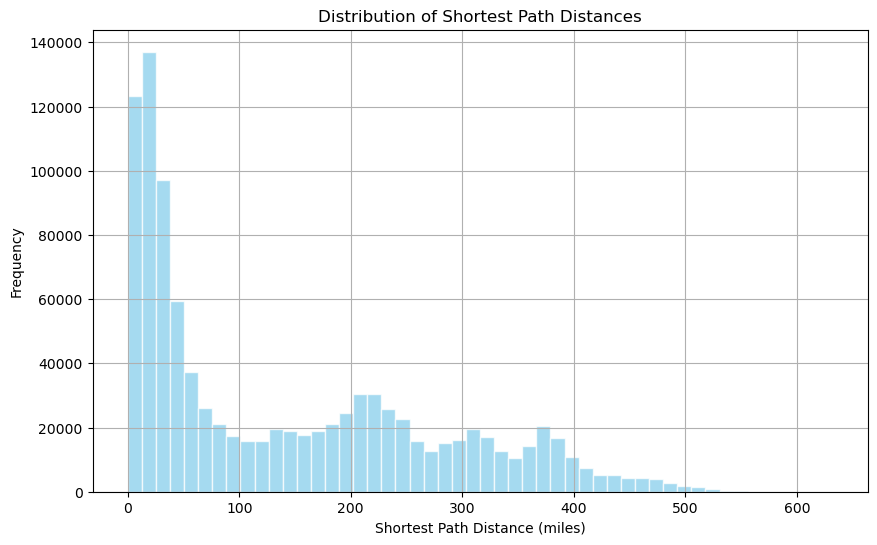

In [540]:
unique_nodes = np.unique(pd.concat([df_merged[" first bus number"], df_merged[" second bus number"]])) # find all unique nodes
node_to_index_dict = {node: idx for idx, node in enumerate(unique_nodes)} # create the node to index  mapping: {123:0, ...}

num_nodes = len(unique_nodes) # Number of unique nodes

# create csr_matrix: efficient graph computations and algebra
tails = df_merged[" first bus number"].map(node_to_index_dict) # csr_matrix requires integer indices
heads = df_merged[" second bus number"].map(node_to_index_dict)
dis = df_merged["straight_distance(miles)"]

spmat = sp.csr_matrix((dis, (tails, heads)), shape=(num_nodes, num_nodes))

# use Dijkstra to get the shortes distance
dist_matrix, predecessors = csgraph.dijkstra(spmat, directed=False, return_predecessors=True) # no specified source since we want to choose random points
# for i in range(num_nodes):
# print("Shortest path length to {}: {}".format(i, dist_matrix[i]))


n = 1000000 # 1 million times
shortest_path_lengths = []
indices = np.arange(num_nodes) # creates an array of node indices: array([0, 1, 2, ..., num_nodes-1]), which will be used for random sampling
np.random.seed(42)

for _ in tqdm(range(n)): # loop for n timess
    node_a, node_b = np.random.choice(indices, size=2, replace=False) # replace = False ensures no duplicate selection 
    distance = dist_matrix[node_a, node_b]
    if np.isfinite(distance): # check if the distance is a valid finite number
        shortest_path_lengths.append(distance)
    else:
        print(f'There is no shortest path bewteen {node_a} and {node_b}.') # if there is isolated nodes or disconnected subgraphs, show it

plt.figure(figsize=(10, 6))
plt.hist(shortest_path_lengths, bins=50, alpha=0.75, edgecolor='white', color='skyblue')
plt.xlabel("Shortest Path Distance (miles)")
plt.ylabel("Frequency")
plt.title("Distribution of Shortest Path Distances")
plt.grid(True)
plt.show()


In [541]:
# Another method
# G = nx.Graph()

# for _, row in df_merged.iterrows():
#     G.add_edge(row[" first bus number"], row[" second bus number"], weight=row["straight_distance(miles)"])

# num_samples = 1000000
# shortest_path_lengths = []

# nodes = list(G.nodes())
# num_nodes = len(nodes)

# for _ in tqdm(range(num_samples)):
#     node_a, node_b = np.random.choice(nodes, size=2, replace=False)
#     try:
#         length = nx.dijkstra_path_length(G, source=node_a, target=node_b, weight="weight")
#         shortest_path_lengths.append(length)
#     except nx.NetworkXNoPath:
#         pass  # skip if there's no path between nodes

# plt.figure(figsize=(10, 6))
# plt.hist(shortest_path_lengths, bins=50, alpha=0.75, edgecolor='white', color='skyblue')
# plt.xlabel("Shortest Path Distance (miles)")
# plt.ylabel("Frequency")
# plt.title("Distribution of Shortest Path Distances")
# plt.grid(True)
# plt.show()


### 2. Implement the algorithm for the minimum-cost node tour problem (i.e., the node inspection problem) on this data.  You only need to examine **one** pairing of the odd nodes. You only need to report on the **cost** of your tour, that is to say you do not need to implement the splicing operation.

In [542]:
G = nx.Graph()
for _, row in df_merged.iterrows():
    G.add_edge(row[" first bus number"], row[" second bus number"], weight=row["straight_distance(miles)"])

MST = nx.minimum_spanning_tree(G, weight="weight", algorithm="kruskal") # get the MST


odd_degree_nodes = [node for node in MST.nodes if MST.degree(node) % 2 == 1] # find odd nodes
if len(odd_degree_nodes) % 2 != 0:
    raise ValueError("The number of odd-degree nodes must be even for pairing.") # since we need to connect all odd nodes

shortest_paths_dict = dict(nx.all_pairs_dijkstra_path_length(G, weight="weight"))

def compute_random_pairing_cost():
    random.seed(52)
    random.shuffle(odd_degree_nodes)
    matching_cost = 0
    for i in range(0, len(odd_degree_nodes), 2):
        # find node_1 from the dict, if not find, return {} to prevent errors.
        # then find according node_2 from dict of node_1, which is the shortest path from node 1 to node 2, 
        # if not find, return inf means they are not connected.
        node_1, node_2 = odd_degree_nodes[i], odd_degree_nodes[i + 1]
        matching_cost += shortest_paths_dict.get(node_1, {}).get(node_2, np.inf)
    return matching_cost

one_pairing_cost = compute_random_pairing_cost()
original_cost = sum(edge[2]['weight'] for edge in MST.edges(data=True))
total_tour_cost_one =  original_cost + one_pairing_cost
print(f"Total cost of the minimum-cost node tour (one random pairing): {total_tour_cost_one}")

Total cost of the minimum-cost node tour (one random pairing): 47586.619677446535


### 3. Now repeat step 2, examining *random* pairings of the odd nodes.  Perform this step for at least 1000 pairings.  The TA/CA may ask to perform more.  Report on the best solution you find.

In [546]:
num_trials = 1000
best_pairing_cost = float('inf')
best_pairing = None  # store the best_pair for question 4 

for _ in tqdm(range(num_trials)):
    random.shuffle(odd_degree_nodes)
    current_pairing = []  # store the current pairing
    cost = 0
    
    for i in range(0, len(odd_degree_nodes), 2):
        node_1, node_2 = odd_degree_nodes[i], odd_degree_nodes[i + 1]
        current_pairing.append((node_1, node_2))  # store the pairing
        cost += shortest_paths_dict.get(node_1, {}).get(node_2, np.inf)

    if cost < best_pairing_cost:
        best_pairing_cost = cost
        best_pairing = current_pairing[:]  # save the best pairing

total_tour_cost_best = original_cost + best_pairing_cost
print(f"Total cost of the minimum-cost node tour (best of 1000 random pairings): {total_tour_cost_best}")


100%|██████████| 1000/1000 [00:00<00:00, 3202.75it/s]

Total cost of the minimum-cost node tour (best of 1000 random pairings): 43799.778250527386


### 4. Extra credit (**only do this if 1-3 are 100% completed**).  Use the 'splicing' algorithm to actually compute the tour itself, for the best solution obtained in Step 3.

In [547]:
eulerian_graph = MST.copy()
# add edges from the best pairing found in Question 3
for node_1, node_2 in best_pairing:
    eulerian_graph.add_edge(node_1, node_2, weight=shortest_paths_dict.get(node_1, {}).get(node_2, np.inf))

eulerian_tour = list(nx.eulerian_circuit(eulerian_graph, keys=False))

# total_tour_cost = sum(eulerian_graph[u][v]["weight"] for u, v in eulerian_tour)
visited_edges = set()
total_tour_cost = 0

for u, v in eulerian_tour:
    if (u, v) not in visited_edges and (v, u) not in visited_edges:
        total_tour_cost += eulerian_graph[u][v]["weight"]
        visited_edges.add((u, v))


print(f"Total cost of the Eulerian Tour (spliced from best pairing): {total_tour_cost}")
print(f"Eulerian Tour: {eulerian_tour}")


Total cost of the Eulerian Tour (spliced from best pairing): 43799.778250527466
Eulerian Tour: [(123.0, 5134.0), (5134.0, 5130.0), (5130.0, 5044.0), (5044.0, 4951.0), (4951.0, 4949.0), (4949.0, 4945.0), (4945.0, 4943.0), (4943.0, 4941.0), (4941.0, 4939.0), (4939.0, 4979.0), (4979.0, 4999.0), (4999.0, 4998.0), (4998.0, 4995.0), (4995.0, 4994.0), (4994.0, 5321.0), (5321.0, 5324.0), (5324.0, 5342.0), (5342.0, 5341.0), (5341.0, 5332.0), (5332.0, 5306.0), (5306.0, 7553.0), (7553.0, 7577.0), (7577.0, 7578.0), (7578.0, 7581.0), (7581.0, 7579.0), (7579.0, 7570.0), (7570.0, 7571.0), (7571.0, 3617.0), (3617.0, 7603.0), (7603.0, 7604.0), (7604.0, 7605.0), (7605.0, 7606.0), (7606.0, 7612.0), (7612.0, 76563.0), (76563.0, 3616.0), (3616.0, 3595.0), (3595.0, 6463.0), (6463.0, 6462.0), (6462.0, 6452.0), (6452.0, 6442.0), (6442.0, 6430.0), (6430.0, 6425.0), (6425.0, 6673.0), (6673.0, 6674.0), (6674.0, 76458.0), (76458.0, 3506.0), (3506.0, 3508.0), (3508.0, 76462.0), (76462.0, 8134.0), (8134.0, 4074.0),

In [ ]:
# Another Method: investigate each step
eulerian_graph = nx.MultiGraph()
eulerian_graph.add_edges_from(MST.edges(data=True))


added = set()
for node_1, node_2 in best_pairing:
    shortest_path = nx.shortest_path(G, source=node_1, target=node_2, weight="weight")
    # print(shortest_path)
    # add the edges along the shortest path into the MultiGraph
    for i in range(len(shortest_path) - 1):
        u, v = shortest_path[i], shortest_path[i + 1]
        weight = G[u][v]["weight"]
        eulerian_graph.add_edge(u, v, weight=weight)

eulerian_tour = list(nx.eulerian_circuit(eulerian_graph)) # compute the Eulerian circuit

# compute the total cost of the Eulerian tour
visited_edges = set()
total_tour_cost = 0

for u, v in eulerian_tour:
    # ensure each edge is counted only once per traversal
    if (u, v, 0) not in visited_edges and (v, u, 0) not in visited_edges:
        for k in eulerian_graph[u][v]:
        
            total_tour_cost += eulerian_graph[u][v][k]["weight"]
        visited_edges.add((u, v, 0)) 
            
print(f"Total cost of the Eulerian Tour (spliced from best pairing): {total_tour_cost}")
print(f"Eulerian Tour: {eulerian_tour}")


Total cost of the Eulerian Tour (spliced from best pairing): 43799.77825052745
Eulerian Tour: [(123.0, 4232.0), (4232.0, 4231.0), (4231.0, 3610.0), (3610.0, 76560.0), (76560.0, 7635.0), (7635.0, 3625.0), (3625.0, 7635.0), (7635.0, 76563.0), (76563.0, 3613.0), (3613.0, 76563.0), (76563.0, 7635.0), (7635.0, 76563.0), (76563.0, 7635.0), (7635.0, 76563.0), (76563.0, 7635.0), (7635.0, 76560.0), (76560.0, 7635.0), (7635.0, 76560.0), (76560.0, 7635.0), (7635.0, 76560.0), (76560.0, 7635.0), (7635.0, 76560.0), (76560.0, 3610.0), (3610.0, 76560.0), (76560.0, 3610.0), (3610.0, 76560.0), (76560.0, 3610.0), (3610.0, 76560.0), (76560.0, 3610.0), (3610.0, 7638.0), (7638.0, 3610.0), (3610.0, 7638.0), (7638.0, 3610.0), (3610.0, 7638.0), (7638.0, 3610.0), (3610.0, 7638.0), (7638.0, 3610.0), (3610.0, 7638.0), (7638.0, 3610.0), (3610.0, 7638.0), (7638.0, 3610.0), (3610.0, 7638.0), (7638.0, 5475.0), (5475.0, 7638.0), (7638.0, 5475.0), (5475.0, 7638.0), (7638.0, 5475.0), (5475.0, 7638.0), (7638.0, 5475.0), 